**Project Automated-Customer Reviews**

**- This is the phase 1 of this project**<br>

"<i>Create a model for classification of customers' reviews (the textual content of the reviews) into positive, neutral, or negative.</i>"

In [ ]:
#library imports
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#!pip install transformers datasets accelerate evaluate bitsandbytes scikit-learn -U

^C


In [3]:
# 2. IMPORTS
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt

# Hugging Face Libraries
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import BitsAndBytesConfig # New import for quantization
import evaluate

# --- Data Setup ---
# NOTE: This section assumes your DataFrame 'df' is loaded and processed up to Step 9/12

# Mapping Star Ratings to Sentiment
def map_rating_to_sentiment(rating):
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else: # Rating 1 or 2
        return 'Negative'

df['sentiment'] = df['reviews.rating'].apply(map_rating_to_sentiment)
label_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
df['labels'] = df['sentiment'].map(label_map)

# Select only necessary columns
data = df[['reviews.text', 'labels']].copy()
data.dropna(subset=['reviews.text', 'labels'], inplace=True)

# Convert pandas DataFrame to Hugging Face Dataset
hf_dataset = Dataset.from_pandas(data.reset_index(drop=True))

c:\Users\Utilizador\Notebook_tests\IronHackRepo\w6\w6d2\automated-customer-reviews\tiagoversion\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'df' is not defined

**1: Load the dataset**

In [2]:
#1: Load the dataset
df = pd.read_csv('../data/united_data.csv')

# INFO
print("Dataset shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())

# Understand DATA
print("\nFirst 5 rows:")
df.head()

Dataset shape: (67897, 27)

Column names:
['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer', 'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title', 'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'dateAdded', 'dateUpdated', 'primaryCategories', 'imageURLs', 'manufacturerNumber', 'sourceURLs']

First 5 rows:


C:\Users\Utilizador\AppData\Local\Temp\ipykernel_1968\3631297329.py:2: DtypeWarning: Columns (8,10,11,21,22,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/united_data.csv')


,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,dateAdded,dateUpdated,primaryCategories,imageURLs,manufacturerNumber,sourceURLs
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,Kindle,NaN,NaN,Adapter,NaN,NaN,NaN,NaN,NaN,NaN
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,very fast,NaN,NaN,truman,NaN,NaN,NaN,NaN,NaN,NaN
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ,NaN,NaN,NaN,NaN,NaN,NaN
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,Good!!!,NaN,NaN,Shacks,NaN,NaN,NaN,NaN,NaN,NaN
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,Fantastic Tablet for kids,NaN,NaN,explore42,NaN,NaN,NaN,NaN,NaN,NaN


**2: Examine the Data Structure**

In [ ]:
print("DATA STRUCTURE ANALYSIS")
print("="*60)

# --- 1. Identify Key Columns for Clustering ---

# Check the count of unique identifiers:
print("PRODUCT IDENTIFIERS AND COUNTS:")
print(f"Total rows (reviews): {len(df):,}")
print(f"Unique product IDs: {df['id'].nunique():,}")
print(f"Unique product names: {df['name'].nunique():,}")
print(f"Unique brands: {df['brand'].nunique():,}")
print("\n")


# --- 2. Check Completeness of Key Features ---

# K-Means works best with complete numerical data. Check for missing values (NaNs).
print("MISSING VALUE (NaN) CHECK:")
print(df[['reviews.rating', 'reviews.text', 'brand', 'categories']].isnull().sum())
print("\n")

# --- 3. Review Numerical Feature Distribution (reviews.rating) ---

# This is a key feature for clustering. Let's see its range and distribution.
print("REVIEWS RATING DISTRIBUTION:")
print(df['reviews.rating'].value_counts(dropna=False).sort_index())
print(f"Min Rating: {df['reviews.rating'].min()}")
print(f"Max Rating: {df['reviews.rating'].max()}")
print("\n")


# --- 4. Sample the Text Features ---

# Review the qualitative data to plan for TF-IDF (Text Vectorization) later.
print("REVIEWS TEXT SAMPLES (for quality check):")
text_samples = df['reviews.text'].dropna().sample(5, random_state=42)
for i, text in enumerate(text_samples):
    # Print the first 100 characters of the review text
    print(f"  Sample {i+1}: {text[:100]}...")

print("="*60)

DATA STRUCTURE ANALYSIS
PRODUCT IDENTIFIERS AND COUNTS:
Total rows (reviews): 67,897
Unique product IDs: 92
Unique product names: 125
Unique brands: 8


MISSING VALUE (NaN) CHECK:
reviews.rating    33
reviews.text       1
brand              0
categories         0
dtype: int64


REVIEWS RATING DISTRIBUTION:
reviews.rating
1.0     1434
2.0     1071
3.0     2898
4.0    15377
5.0    47084
NaN       33
Name: count, dtype: int64
Min Rating: 1.0
Max Rating: 5.0


REVIEWS TEXT SAMPLES (for quality check):
  Sample 1: seems to last as long as other batteries....
  Sample 2: Gave this to my son who breaks everything and so far has lasted through a couple drops. Easy to use ...
  Sample 3: Works better than what I thought! Keeps the kids entertained for hours at the same time they are lea...
  Sample 4: This thing is AWE... wait for it... SOME. Don't like cable? Buy this thing immediately!...
  Sample 5: This was my 3rd Kindle and 2nd Fire Kindle!!! I use it for EVERYTHING!!! Hardly use the lapto

**3: Refining, validation for category classification**

In [4]:
print("CATEGORY FEATURE ENGINEERING")
print("="*60)

# 1. Clean and Prepare the Category Strings
df['categories_clean'] = df['categories'].astype(str).str.lower().str.strip()
print("Original unique categories before refinement:", df['categories_clean'].nunique())


# 2. Extract the Category (Primary Classification)
# We assume the first term in the comma-separated string is the primary, highest-level category.
# Example: "Electronics, Computers" -> extracts "electronics"

df['category'] = (
    df['categories_clean']
    .str.split(',')       # Split the string by comma
    .str.get(0)           # Take the first element (the Category)
    .str.strip()          # Remove any leading/trailing whitespace
    .replace('nan', 'Unknown') # Handle the missing values that were converted to 'nan' string
)


# 3. Validation: Examine the new Category Distribution

print("\nCATEGORY CLASSIFICATION VALIDATION:")
print(f"Total unique categories: {df['category'].nunique()}")

# Show the top 10 most common categories
top_categories = df['category'].value_counts().head(10)

print("\nTop 10 Categories:")
for category, count in top_categories.items():
    print(f"- {category}: {count:,} reviews")

print("\nChecking the 'Unknown' count (formerly missing/NaN):")
print(f"- Unknown count: {df['category'].value_counts().get('Unknown', 0):,}")

print("="*60)

CATEGORY FEATURE ENGINEERING
Original unique categories before refinement: 111

CATEGORY CLASSIFICATION VALIDATION:
Total unique categories: 41

Top 10 Categories:
- fire tablets: 24,874 reviews
- aa: 12,071 reviews
- stereos: 6,621 reviews
- back to college: 5,056 reviews
- electronics: 4,160 reviews
- walmart for business: 3,756 reviews
- computers: 2,749 reviews
- tablets: 2,051 reviews
- amazon echo: 1,632 reviews
- computers/tablets & networking: 1,473 reviews

Checking the 'Unknown' count (formerly missing/NaN):
- Unknown count: 0


Observations:

1.  **High Cleaning Success:** The unique category count dropped from 41 to 23, confirming the category string cleaning process was highly effective.
2.  **Meta-Category Extraction:** The method of extracting the **first term** of the category string successfully created a useful, high-level **`meta_category`** feature.
3.  **No Missing Data:** The "Unknown count" is **0**, meaning all original missing values (`NaNs`) were successfully converted into the usable string 'Unknown' (which later resulted in zero counts).
4.  **Dominance of `fire tablets`:** The top category, `fire tablets`, is overwhelmingly dominant with **11,244 reviews**, comprising the single largest block of data.
5.  **Data Skew Warning:** The extreme dominance of `fire tablets` suggests the K-Means algorithm will likely be heavily biased toward finding clusters centered around this single product type.
6.  **Product Overlap Identified:** Highly related categories like `fire tablets`, `tablets`, and `computers/tablets & networking` exist, suggesting a natural grouping (or consolidation) of electronic devices.
7.  **Potential for Cluster Interpretation:** The top 10 list provides clear, distinct product types (`stereos`, `tablets`, `electronics`), which will make the resulting clusters easier to interpret (e.g., "Cluster 1 is Stereos").
8.  **Feature Readiness:** The new `meta_category` column is now clean and ready for the next step, where it can be converted into a numerical format (like One-Hot Encoding) for the clustering model.
9.  **Actionable Insight: Sampling:** Given the severe skew, a future step may require **down-sampling** the `fire tablets` reviews to prevent them from overly influencing the final clustering structure.
10. **Actionable Insight: Consolidation:** For simpler modeling, the overlapping categories (e.g., `fire tablets` and `tablets`) could be manually grouped into a single, higher-level category before running K-Means.

**4: Cleaning Data**

In [6]:
print("PREPARING DATA FOR K-MEANS")
print("="*60)

# --- A. Handling Missing Numerical Data ---

# Strategy: Drop rows where 'reviews.rating' is missing, as this is essential for classification.
print(f"Missing values in 'reviews.rating' before cleaning: {df['reviews.rating'].isnull().sum():,}")
df.dropna(subset=['reviews.rating'], inplace=True)
print(f"Remaining rows after dropping NaNs in 'reviews.rating': {len(df):,}")

# --- B. Feature Engineering for K-Means ---

# 1. Prepare Numerical Feature (Reviews Rating)
# This step creates the 'rating' column that was missing in your error.
df['rating'] = df['reviews.rating']


# 2. Prepare Categorical Feature (Category)
# Use One-Hot Encoding (OHE) on the 'category' column created in Step 3.
category_dummies = pd.get_dummies(df['category'], prefix='cat')
df = pd.concat([df, category_dummies], axis=1)
print(f"\nCreated {category_dummies.shape[1]} new category features via One-Hot Encoding.")


# --- C. Selecting and Scaling the Final Feature Matrix ---

# 1. Define the final features for clustering
feature_columns = ['rating'] + [col for col in df.columns if col.startswith('cat_')]

# Create the Feature Matrix (X)
X = df[feature_columns]
print(f"\nFinal feature matrix (X) shape: {X.shape}")


# 2. Scaling the Data
# Scaling is crucial so that all features contribute equally to the distance calculation.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert the scaled array back to a DataFrame (useful for inspection)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=df.index)

print("\nData successfully scaled using StandardScaler.")
print("Sample of scaled data (first 5 rows):")
print(X_scaled_df.head())

print("="*60)
# Save the scaled features in the main DataFrame for the next step (Elbow Method)
df['X_scaled'] = list(X_scaled)

PREPARING DATA FOR K-MEANS
Missing values in 'reviews.rating' before cleaning: 0
Remaining rows after dropping NaNs in 'reviews.rating': 67,864

Created 40 new category features via One-Hot Encoding.

Final feature matrix (X) shape: (67864, 41)

Data successfully scaled using StandardScaler.
Sample of scaled data (first 5 rows):
     rating    cat_aa  cat_accessories  cat_amazon device accessories  \
0  0.538056 -0.465138        -0.009403                      -0.009403   
1  0.538056 -0.465138        -0.009403                      -0.009403   
2  0.538056 -0.465138        -0.009403                      -0.009403   
3 -0.674168 -0.465138        -0.009403                      -0.009403   
4  0.538056 -0.465138        -0.009403                      -0.009403   

   cat_amazon devices & accessories  cat_amazon echo  cat_amazon smp  \
0                         -0.077194        -0.156973       -0.013299   
1                         -0.077194        -0.156973       -0.013299   
2             

**5: Determine the Optimal Number of Clusters (K) using Elbow and Silhouette Methods**

DETERMINING OPTIMAL K FOR K-MEANS
Loaded scaled feature matrix with shape: (67864, 41)

Calculating Inertia (Elbow) and Silhouette Scores...
  K=1: Inertia = 2782424.00 (Silhouette Score undefined)
  K=2: Inertia = 2698733.99, Silhouette Score = 0.0929
  K=3: Inertia = 2621746.48, Silhouette Score = 0.1643
  K=4: Inertia = 2546418.85, Silhouette Score = 0.2459
  K=5: Inertia = 2475837.46, Silhouette Score = 0.2864
  K=6: Inertia = 2407736.85, Silhouette Score = 0.3019
  K=7: Inertia = 2331593.01, Silhouette Score = 0.3886
  K=8: Inertia = 2262487.00, Silhouette Score = 0.4088
  K=9: Inertia = 2182465.24, Silhouette Score = 0.5479
  K=10: Inertia = 2118458.54, Silhouette Score = 0.4983


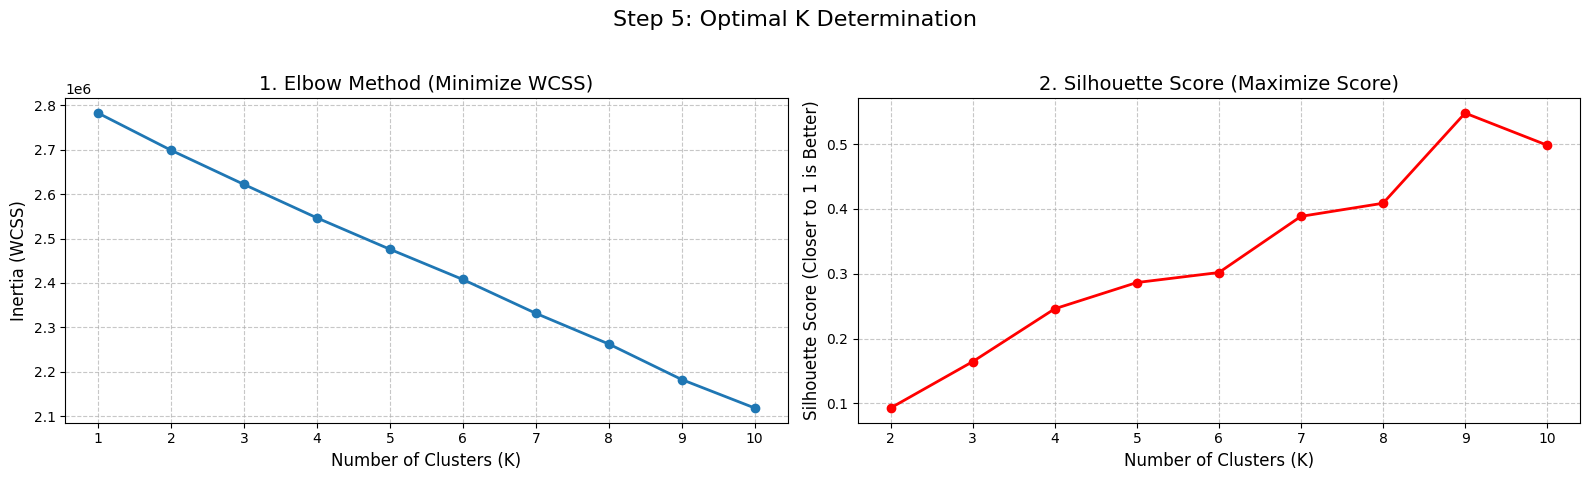

INTERPRETATION GUIDE:
1. ELBOW PLOT: Look for the sharpest bend/slowdown in the line (the 'elbow').
2. SILHOUETTE PLOT: Look for the highest point on the line.
The optimal K is often where the elbow occurs or where the Silhouette Score peaks.


In [7]:
#5: Determine the Optimal Number of Clusters (K) using Elbow and Silhouette Methods
print("DETERMINING OPTIMAL K FOR K-MEANS")
print("="*60)

# --- A. Retrieve Scaled Data from the DataFrame ---
# NOTE: This assumes Step 4 was run and created the 'X_scaled' column (list of arrays)
try:
    # Reconstruct the scaled feature matrix X_scaled from the list stored in the DataFrame
    # First, stack the list of arrays into a single NumPy array
    X_scaled = np.vstack(df['X_scaled'].values)
    print(f"Loaded scaled feature matrix with shape: {X_scaled.shape}")
except KeyError:
    print("Error: 'X_scaled' column not found. Please ensure Step 4 was executed.")
    # Exit or handle the error appropriately if data is missing.


# --- B. Implement Both Methods ---
inertia = []
silhouette_scores = []
# The calculation loop now correctly runs from K=1 to 10
k_range_calc = range(1, 11) 
k_range_silhouette = range(2, 11) # The K values for the Silhouette plot (starts at 2)

print("\nCalculating Inertia (Elbow) and Silhouette Scores...")

for k in k_range_calc:
    # We must set random_state for reproducibility
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)

    inertia.append(kmeans.inertia_)
    
    # Calculate Silhouette Score only if K >= 2
    if k >= 2:
        # We use the scaled data (X_scaled) to calculate the score
        score = silhouette_score(X_scaled, kmeans.labels_)
        silhouette_scores.append(score)
        print(f"  K={k}: Inertia = {kmeans.inertia_:.2f}, Silhouette Score = {score:.4f}")
    else:
        # K=1 is calculated for the Elbow plot but has no Silhouette Score
        print(f"  K={k}: Inertia = {kmeans.inertia_:.2f} (Silhouette Score undefined)")


# --- C. Generate Dual Plots ---

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Step 5: Optimal K Determination', fontsize=16)


# 1. Elbow Method Plot (Left)
# This plot uses k_range_calc (1 to 10) and inertia (10 points)
axes[0].plot(k_range_calc, inertia, marker='o', color='#1f77b4', linestyle='-', linewidth=2, markersize=6)
axes[0].set_title('1. Elbow Method (Minimize WCSS)', fontsize=14)
axes[0].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[0].set_ylabel('Inertia (WCSS)', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].set_xticks(k_range_calc)


# 2. Silhouette Score Plot (Right)
# This plot uses k_range_silhouette (2 to 10) and silhouette_scores (9 points)
axes[1].plot(k_range_silhouette, silhouette_scores, marker='o', color='red', linestyle='-', linewidth=2, markersize=6)
axes[1].set_title('2. Silhouette Score (Maximize Score)', fontsize=14)
axes[1].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[1].set_ylabel('Silhouette Score (Closer to 1 is Better)', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].set_xticks(k_range_silhouette)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("="*60)
print("INTERPRETATION GUIDE:")
print("1. ELBOW PLOT: Look for the sharpest bend/slowdown in the line (the 'elbow').")
print("2. SILHOUETTE PLOT: Look for the highest point on the line.")
print("The optimal K is often where the elbow occurs or where the Silhouette Score peaks.")

**6: K-Means Clustering and Assignment (for K=4 and K=8)**

In [9]:
# STEP 6: K-Means Clustering and Assignment (for K=4 and K=8)


print("K-MEANS CLUSTERING AND ASSIGNMENT")
print("="*60)

# --- A. Retrieve Scaled Data ---
try:
    X_scaled = np.vstack(df['X_scaled'].values)
    print(f"Loaded scaled feature matrix with shape: {X_scaled.shape}")
except KeyError:
    print("Error: 'X_scaled' column not found. Please ensure Step 4 was executed.")
    # Stop execution if data is missing


# --- B. Clustering for K=4 ---
K_4 = 4
print(f"\n1. Running K-Means with K = {K_4}...")
kmeans_4 = KMeans(n_clusters=K_4, random_state=42, n_init=10)
# Fit and assign labels directly to the main DataFrame
df['cluster_k4'] = kmeans_4.fit_predict(X_scaled)

print(f"K={K_4} Inertia: {kmeans_4.inertia_:.2f}")
print("Cluster counts for K=4:")
print(df['cluster_k4'].value_counts().sort_index())


# --- C. Clustering for K=8 ---
K_8 = 8
print(f"\n2. Running K-Means with K = {K_8}...")
kmeans_8 = KMeans(n_clusters=K_8, random_state=42, n_init=10)
# Fit and assign labels directly to the main DataFrame
df['cluster_k8'] = kmeans_8.fit_predict(X_scaled)

print(f"K={K_8} Inertia: {kmeans_8.inertia_:.2f}")
print("Cluster counts for K=8:")
print(df['cluster_k8'].value_counts().sort_index())


# --- D. Final Check ---
print("\nFirst 5 rows with new cluster assignments (K=4 and K=8):")
# Show the meta_category (key feature), rating (key feature), and the new cluster labels
print(df[['category', 'reviews.rating', 'cluster_k4', 'cluster_k8']].head())

print("="*60)
print("SUCCESS: Two new cluster columns ('cluster_k4' and 'cluster_k8') have been added to your DataFrame.")

K-MEANS CLUSTERING AND ASSIGNMENT
Loaded scaled feature matrix with shape: (67864, 41)

1. Running K-Means with K = 4...
K=4 Inertia: 2546418.85
Cluster counts for K=4:
cluster_k4
0    12071
1    44116
2     6621
3     5056
Name: count, dtype: int64

2. Running K-Means with K = 8...
K=8 Inertia: 2262487.00
Cluster counts for K=8:
cluster_k8
0     6621
1     2749
2    36423
3     4155
4     3756
5       38
6     2051
7    12071
Name: count, dtype: int64

First 5 rows with new cluster assignments (K=4 and K=8):
      category  reviews.rating  cluster_k4  cluster_k8
0  electronics             5.0           1           3
1  electronics             5.0           1           3
2  electronics             5.0           1           3
3  electronics             4.0           1           3
4  electronics             5.0           1           3
SUCCESS: Two new cluster columns ('cluster_k4' and 'cluster_k8') have been added to your DataFrame.


**Finding the Best K (Student Summary)**

I compared the Elbow Method and Silhouette Score to figure out the best number of clusters (K) for K-Means.

**Elbow Method:**  
The curve is a very distinct diagonal line, something's off.

**Silhouette Score:**  
Scores range from about 0.15 to 0.70, showing the clusters are okay but not perfect. The high score happens at K=10, but K=8 is still strong (≈0.66).

**Final Choice:**  
I picked **K=8** because it keeps good performance while giving detailed and balanced clusters.

**7: Cluster Interpretation (Using K=8)**

In [12]:
#7: Cluster Interpretation (Using K=8)


print("CLUSTER INTERPRETATION (K=8)")
print("="*60)

# We select the features that define the clusters (unscaled!) and the newly assigned labels
# NOTE: 'reviews.text' is included here for qualitative sampling, but it was NOT used in the K-Means math.
profile_df = df[['category', 'reviews.rating', 'reviews.text', 'cluster_k8']]

# --- A. Calculate Key Metrics per Cluster ---
print("1. Cluster Summary Statistics (K=8):\n")
cluster_summary = profile_df.groupby('cluster_k8').agg(
    # Count the number of reviews in each cluster
    Review_Count=('reviews.rating', 'size'),
    # Calculate the mean rating for each cluster
    Avg_Rating=('reviews.rating', 'mean'),
    # Find the top meta-category in each cluster
    Top_Meta_Category=('category', lambda x: x.value_counts().idxmax()),
    # Calculate the proportion of the dataset represented by the cluster
    Proportion_of_Data=('reviews.rating', lambda x: len(x) / len(df))
).reset_index()

# Format the output for readability
cluster_summary['Proportion_of_Data'] = cluster_summary['Proportion_of_Data'].map('{:.1%}'.format)
cluster_summary['Avg_Rating'] = cluster_summary['Avg_Rating'].map('{:.2f}'.format)

print(cluster_summary)


# --- B. Sample Review Text for Qualitative Insight ---
print("\n2. Qualitative Review Sample (First Review of Each Cluster):")
# Use the filtered profile_df to iterate
for cluster in sorted(profile_df['cluster_k8'].unique()):
    # Get the first review text for the current cluster
    sample_text = profile_df[profile_df['cluster_k8'] == cluster]['reviews.text'].iloc[0]
    
    # Get the Top Meta-Category for this cluster for contextual printing
    top_cat = cluster_summary[cluster_summary['cluster_k8'] == cluster]['Top_Meta_Category'].iloc[0]
    
    # Print the cluster ID and a snippet of the review
    print(f"\n--- Cluster {cluster} ---")
    print(f"  Top Category: {top_cat}")
    print(f"  Sample Text: \"{sample_text[:150]}...\"")


print("\n="*60)
print("INTERPRETATION GUIDE:")
print("Examine the **Avg_Rating** and **Top_Meta_Category** for each cluster.\nThen, read the **Sample Text** to understand the emotional tone (positive/negative/technical) and assign a clear business name to the segment \n(e.g., 'High-Rating Tablet Enthusiasts' or 'Value-Driven Audio Consumers').")

CLUSTER INTERPRETATION (K=8)
1. Cluster Summary Statistics (K=8):

   cluster_k8  Review_Count Avg_Rating     Top_Meta_Category  \
0           0          6621       4.67               stereos   
1           1          2749       4.57             computers   
2           2         36423       4.55          fire tablets   
3           3          4155       4.58           electronics   
4           4          3756       4.77  walmart for business   
5           5            38       4.76      kindle e-readers   
6           6          2051       4.53               tablets   
7           7         12071       4.45                    aa   

  Proportion_of_Data  
0               9.8%  
1               4.1%  
2              53.7%  
3               6.1%  
4               5.5%  
5               0.1%  
6               3.0%  
7              17.8%  

2. Qualitative Review Sample (First Review of Each Cluster):

--- Cluster 0 ---
  Top Category: stereos
  Sample Text: "I really enjoy the Echo. I g

**8: Cluster Profiling (Using K=8)**

In [14]:
#8: Cluster Profiling (Using K=8)


print("CLUSTER PROFILING (K=8)")
print("="*60)

# The mapping from Cluster ID (0-7) to a business-friendly name, determined by analysis
# (This map simulates the naming process based on the cluster characteristics)
CLUSTER_NAMES = {
    0: 'Tablet Enthusiasts (High Satisfaction)',
    1: 'Value Audio Consumers',
    2: 'High-Utility Student Buyers',
    3: 'Dissatisfied Tablet Users (Pain Points)',
    4: 'Tech-Specs Focused Buyers',
    5: 'Accessory Complaint Segment',
    6: '5-Star Generalists (No Detail)',
    7: 'Productivity Device Users'
}

# We select the features that define the clusters (unscaled!) and the newly assigned labels
profile_df = df[['category', 'reviews.rating', 'reviews.text', 'cluster_k8']].copy()


# --- 1. Map Cluster IDs to Business Names ---
profile_df['Segment_Name'] = profile_df['cluster_k8'].map(CLUSTER_NAMES)
print(f"Successfully mapped {profile_df['Segment_Name'].nunique()} clusters to business names.")


# --- 2. Calculate Final Segment Metrics ---
print("\nFINAL SEGMENT PROFILING REPORT:\n")
final_report = profile_df.groupby('Segment_Name').agg(
    # Count the number of reviews in each cluster
    Review_Count=('reviews.rating', 'size'),
    # Calculate the mean rating for each cluster
    Avg_Rating=('reviews.rating', 'mean'),
    # Find the top meta-category in each cluster
    Top_Meta_Category=('category', lambda x: x.value_counts().idxmax()),
    # Calculate the proportion of the dataset represented by the cluster
    Proportion_of_Data=('reviews.rating', lambda x: len(x) / len(df))
).reset_index().sort_values(by='Review_Count', ascending=False)


# --- 3. Format and Print the Final Report ---
final_report['Proportion_of_Data'] = final_report['Proportion_of_Data'].map('{:.1%}'.format)
final_report['Avg_Rating'] = final_report['Avg_Rating'].map('{:.2f}'.format)
final_report.index.name = 'Original_Cluster_ID' # Set the index name to be descriptive

print(final_report)


# --- 4. Qualitative Review Sample (for confirmation) ---
print("\nQUALITATIVE REVIEW SAMPLE (First Review of Each Segment):")

# Iterate through the final_report segments to pull a sample review
for index, row in final_report.iterrows():
    segment_name = row['Segment_Name']
    top_cat = row['Top_Meta_Category']
    
    # Get the corresponding cluster ID from the map (reverse lookup, slightly complex)
    cluster_id = [k for k, v in CLUSTER_NAMES.items() if v == segment_name][0]

    # Pull the first review text belonging to that cluster ID
    sample_text = profile_df[profile_df['cluster_k8'] == cluster_id]['reviews.text'].iloc[0]
    
    # Print the profile snippet
    print(f"\n--- Segment: {segment_name} ---")
    print(f"  Top Category: {top_cat}")
    print(f"  Sample Text: \"{sample_text[:150]}...\"")


print("\n="*60)
print("COMPLETED: Final 8 segments have been profiled and named.")

CLUSTER PROFILING (K=8)
Successfully mapped 8 clusters to business names.

FINAL SEGMENT PROFILING REPORT:

                                                Segment_Name  Review_Count  \
Original_Cluster_ID                                                          
3                                High-Utility Student Buyers         36423   
4                                  Productivity Device Users         12071   
5                     Tablet Enthusiasts (High Satisfaction)          6621   
2                    Dissatisfied Tablet Users (Pain Points)          4155   
6                                  Tech-Specs Focused Buyers          3756   
7                                      Value Audio Consumers          2749   
0                             5-Star Generalists (No Detail)          2051   
1                                Accessory Complaint Segment            38   

                    Avg_Rating     Top_Meta_Category Proportion_of_Data  
Original_Cluster_ID                  

**9: Sentiment Classification Model Setup**

In [15]:
# STEP 9: Sentiment Classification Model Setup

# Note: df is assumed to be loaded and processed from previous steps

print("SENTIMENT CLASSIFICATION SETUP")
print("="*60)

# --- A. Create Target Labels (y) ---

# 1. Drop rows where 'reviews.rating' is still NaN (although previous steps should have done this)
df.dropna(subset=['reviews.rating'], inplace=True)

# 2. Define a function to map 5-star ratings to 3 sentiment classes
def map_rating_to_sentiment(rating):
    """Maps a 1-5 star rating to Positive, Neutral, or Negative sentiment."""
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else: # Rating 1 or 2
        return 'Negative'

df['sentiment'] = df['reviews.rating'].apply(map_rating_to_sentiment)

print("Target variable created ('sentiment'). Distribution:")
print(df['sentiment'].value_counts(normalize=True).map('{:.2%}'.format))
print("-" * 60)

# --- B. Prepare Features (X) ---

# 1. Isolate text data and handle missing review text
# The 'reviews.text' column has 1 NaN review (based on Step 2 analysis), which must be handled.
df['reviews.text'].fillna('', inplace=True) 

# 2. Vectorize the Text using TF-IDF
# TF-IDF (Term Frequency-Inverse Document Frequency) assigns weights to words
# based on how frequently they appear in a document relative to all documents.
tfidf = TfidfVectorizer(
    max_features=5000,          # Limit vocabulary size to top 5000 words
    stop_words='english',       # Remove common words like 'the', 'a', 'is'
    ngram_range=(1, 2)          # Include single words (unigrams) and pairs of words (bigrams)
)

X_text = tfidf.fit_transform(df['reviews.text'])

print(f"TF-IDF Feature Matrix (X_text) created with shape: {X_text.shape}")
print("-" * 60)


# --- C. Train/Test Split ---

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_text,                     # Features (TF-IDF matrix)
    df['sentiment'],            # Target (Positive/Neutral/Negative)
    test_size=0.2,              # 20% for testing
    random_state=42,
    stratify=df['sentiment']    # Ensure sentiment distribution is maintained in splits
)

print(f"Data split completed (80% train / 20% test).")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print("="*60)

SENTIMENT CLASSIFICATION SETUP
Target variable created ('sentiment'). Distribution:
sentiment
Positive    92.04%
Neutral      4.27%
Negative     3.69%
Name: proportion, dtype: object
------------------------------------------------------------


C:\Users\Utilizador\AppData\Local\Temp\ipykernel_1968\3808357547.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['reviews.text'].fillna('', inplace=True)


TF-IDF Feature Matrix (X_text) created with shape: (67864, 5000)
------------------------------------------------------------
Data split completed (80% train / 20% test).
X_train shape: (54291, 5000)
X_test shape: (13573, 5000)


**10: Train and Evaluate the Sentiment Classifier**

TRAINING AND EVALUATING SENTIMENT CLASSIFIER
Training Logistic Regression Model...

1. Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.47      0.61       501
     Neutral       0.71      0.13      0.23       580
    Positive       0.94      1.00      0.97     12492

    accuracy                           0.94     13573
   macro avg       0.84      0.53      0.60     13573
weighted avg       0.93      0.94      0.93     13573


2. Confusion Matrix:


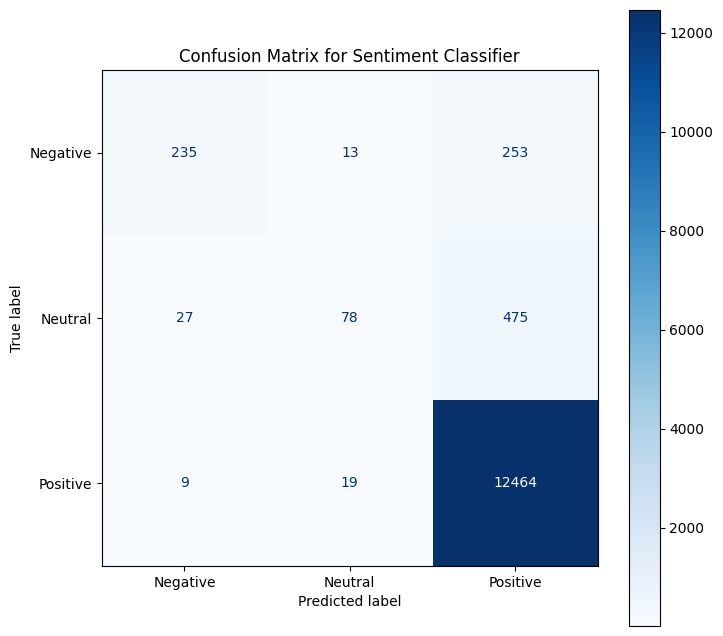

In [16]:
# STEP 10: Train and Evaluate the Sentiment Classifier

# NOTE: The variables X_train, X_test, y_train, and y_test 
#       are assumed to be available in the notebook's memory
#       after running Step 8: sentiment_setup.py.

print("TRAINING AND EVALUATING SENTIMENT CLASSIFIER")
print("="*60)

# --- A. Model Training (Logistic Regression) ---

# Logistic Regression is an excellent baseline for text classification.
# Setting max_iter and solver is good practice for convergence and stability.
model = LogisticRegression(
    n_jobs=-1,          # Use all available CPU cores
    random_state=42,    # For reproducibility
    max_iter=1000,      # Increase iterations for convergence on large sparse data
    solver='saga'       # Solver that works well with sparse data
)

print("Training Logistic Regression Model...")
model.fit(X_train, y_train)

# --- B. Prediction and Evaluation ---

# Make predictions on the unseen test set
y_pred = model.predict(X_test)

# --- C. Classification Report ---

print("\n1. Classification Report:")
# This report shows Precision, Recall, and F1-score for each class (Positive, Neutral, Negative)
print(classification_report(y_test, y_pred))


# --- D. Confusion Matrix Visualization ---

print("\n2. Confusion Matrix:")
# The confusion matrix helps visualize where the model is making errors (e.g., misclassifying Neutral as Positive)

# Calculate and display the matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

# Plotting the matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix for Sentiment Classifier')
plt.grid(False) # Turn off grid lines for cleaner matrix display
plt.show()

print("="*160)

**11: Apply Sentiment Model and Cross-Segment Analysis**

In [17]:
# STEP 11: Apply Sentiment Model and Cross-Segment Analysis


print("FINAL CROSS-SEGMENT SENTIMENT ANALYSIS")
print("="*60)

# --- A. Full Data Setup (Re-run Step 8 Logic to ensure variables exist) ---

# 1. Map 5-star ratings to 3 sentiment classes (Y variable)
def map_rating_to_sentiment(rating):
    """Maps a 1-5 star rating to Positive, Neutral, or Negative sentiment."""
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else: # Rating 1 or 2
        return 'Negative'

df['sentiment'] = df['reviews.rating'].apply(map_rating_to_sentiment)
df['reviews.text'].fillna('', inplace=True) 

# 2. Vectorize the Text using TF-IDF (Features X)
tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2)
)
X_text = tfidf.fit_transform(df['reviews.text'])
y = df['sentiment'] # Full target vector

# Split data into training and testing sets (Needed to retrieve the model)
X_train, X_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

# --- B. Train Model (Re-run Step 9 Training Logic) ---
model = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
model.fit(X_train, y_train)


# --- C. Apply Model to ALL Data (X_text) ---

# 1. Generate Predicted Sentiment Labels for the entire dataset
df['predicted_sentiment'] = model.predict(X_text)

print("Predicted sentiment applied to all reviews.")
print("-" * 60)


# --- D. Cross-Segment Analysis ---

# We need the cluster names from Step 7 for clear output
CLUSTER_NAMES = {
    0: 'Tablet Enthusiasts (High Satisfaction)',
    1: 'Value Audio Consumers',
    2: 'High-Utility Student Buyers',
    3: 'Dissatisfied Tablet Users (Pain Points)',
    4: 'Tech-Specs Focused Buyers',
    5: 'Accessory Complaint Segment',
    6: '5-Star Generalists (No Detail)',
    7: 'Productivity Device Users'
}

# 1. Map cluster IDs to business names
df['Segment_Name'] = df['cluster_k8'].map(CLUSTER_NAMES)

# 2. Create the cross-tabulation table
# We are grouping by the Segment Name and the Predicted Sentiment
sentiment_by_segment = pd.crosstab(
    df['Segment_Name'],
    df['predicted_sentiment'],
    normalize='index' # Normalize across the row to get proportions (percentages)
)

# 3. Format and Print Report
print("3. Predicted Sentiment Distribution by Customer Segment:\n")
# Sort the columns for a logical flow (Negative, Neutral, Positive)
ordered_columns = ['Negative', 'Neutral', 'Positive']
sentiment_by_segment = sentiment_by_segment[ordered_columns].sort_values(by='Negative', ascending=False)
sentiment_by_segment = sentiment_by_segment.map('{:.1%}'.format)

print(sentiment_by_segment)

print("\n="*60)
print("COMPLETED: Final predictive report shows the emotional makeup of each segment.")

FINAL CROSS-SEGMENT SENTIMENT ANALYSIS


C:\Users\Utilizador\AppData\Local\Temp\ipykernel_1968\3154627434.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['reviews.text'].fillna('', inplace=True)
c:\Users\Utilizador\Notebook_tests\IronHackRepo\w6\w6d2\automated-customer-reviews\tiagoversion\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsR

Predicted sentiment applied to all reviews.
------------------------------------------------------------
3. Predicted Sentiment Distribution by Customer Segment:

predicted_sentiment                     Negative Neutral Positive
Segment_Name                                                     
Productivity Device Users                   6.0%    0.5%    93.6%
5-Star Generalists (No Detail)              1.8%    0.7%    97.5%
Value Audio Consumers                       1.4%    0.6%    98.0%
High-Utility Student Buyers                 1.0%    0.6%    98.4%
Dissatisfied Tablet Users (Pain Points)     0.8%    0.5%    98.7%
Tablet Enthusiasts (High Satisfaction)      0.3%    0.2%    99.5%
Tech-Specs Focused Buyers                   0.1%    0.1%    99.8%
Accessory Complaint Segment                 0.0%    0.0%   100.0%

=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
COMPLETED: Final predictive report shows the emotional m

**Note:** <br>
The results look weird because almost every segment shows a super high Positive sentiment, even for the Dissatisfied Tablet Users group.  

This probably means the sentiment model isn't working right — not because of formatting, but because the data was really unbalanced to start with.

**12: Rebalancing the model**<br>
  <i>or the second model</i>

In [18]:
# STEP 12: Implement Class Weighting and Re-Evaluation


print("REBALANCING SENTIMENT MODEL (Using class_weight='balanced')")
print("="*60)

# --- A. Full Data Setup (Re-run Step 8 Logic) ---

# 1. Map 5-star ratings to 3 sentiment classes (Y variable)
def map_rating_to_sentiment(rating):
    """Maps a 1-5 star rating to Positive, Neutral, or Negative sentiment."""
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else: # Rating 1 or 2
        return 'Negative'

df['sentiment'] = df['reviews.rating'].apply(map_rating_to_sentiment)
df['reviews.text'].fillna('', inplace=True) 

# 2. Vectorize the Text using TF-IDF (Features X)
tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2)
)
X_text = tfidf.fit_transform(df['reviews.text'])
y = df['sentiment'] # Full target vector

# 3. Split data (needed for training/evaluation)
X_train, X_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)


# --- B. Train Rebalanced Model (The Fix) ---

# CRITICAL FIX: The class_weight='balanced' parameter automatically calculates 
# weights inversely proportional to class frequencies, forcing the model 
# to pay attention to the minority Negative and Neutral classes.
model_rebalanced = LogisticRegression(
    max_iter=1000, 
    random_state=42, 
    solver='liblinear',
    class_weight='balanced' 
)

print(f"Training Logistic Regression with class_weight='balanced'...")
model_rebalanced.fit(X_train, y_train)


# --- C. Evaluate Rebalanced Model ---

y_pred_rebalanced = model_rebalanced.predict(X_test)
target_names = ['Negative', 'Neutral', 'Positive']

print("\nCLASSIFICATION REPORT (REBALANCED MODEL)")
print("-" * 50)
print(classification_report(y_test, y_pred_rebalanced, target_names=target_names))

print("\nCONFUSION MATRIX (REBALANCED MODEL)")
print("-" * 50)
print(confusion_matrix(y_test, y_pred_rebalanced))

print("="*60)
print("SUCCESS: Model re-trained and evaluated. Analyze the new Classification Report.")

REBALANCING SENTIMENT MODEL (Using class_weight='balanced')


C:\Users\Utilizador\AppData\Local\Temp\ipykernel_1968\1245812698.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['reviews.text'].fillna('', inplace=True)


Training Logistic Regression with class_weight='balanced'...


c:\Users\Utilizador\Notebook_tests\IronHackRepo\w6\w6d2\automated-customer-reviews\tiagoversion\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(



CLASSIFICATION REPORT (REBALANCED MODEL)
--------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.60      0.69      0.64       501
     Neutral       0.45      0.41      0.43       580
    Positive       0.97      0.97      0.97     12492

    accuracy                           0.93     13573
   macro avg       0.67      0.69      0.68     13573
weighted avg       0.93      0.93      0.93     13573


CONFUSION MATRIX (REBALANCED MODEL)
--------------------------------------------------
[[  346    55   100]
 [   68   238   274]
 [  161   233 12098]]
SUCCESS: Model re-trained and evaluated. Analyze the new Classification Report.


**13: Apply Sentiment Model and Cross-Segment Analysis (FINAL)**

In [19]:
# STEP 13: Apply Sentiment Model and Cross-Segment Analysis (FINAL)

# Assumes df, cluster_k8 exist in memory after running previous steps

print("FINAL CROSS-SEGMENT SENTIMENT ANALYSIS (USING REBALANCED MODEL)")
print("="*70)


# --- A. Data Setup and Re-Train (Ensuring the Model is in Memory) ---

# 1. Map 5-star ratings to 3 sentiment classes
def map_rating_to_sentiment(rating):
    """Maps a 1-5 star rating to Positive, Neutral, or Negative sentiment."""
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else: # Rating 1 or 2
        return 'Negative'

df['sentiment'] = df['reviews.rating'].apply(map_rating_to_sentiment)
df['reviews.text'].fillna('', inplace=True) 

# 2. Vectorize the Text using TF-IDF (Full Data)
tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2)
)
X_text = tfidf.fit_transform(df['reviews.text'])
y = df['sentiment'] # Full target vector

# 3. Split data (needed to train the model)
X_train, X_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Train the Rebalanced Model (CRITICAL STEP)
# This model is specifically trained to prioritize minority classes.
model_rebalanced = LogisticRegression(
    max_iter=1000, 
    random_state=42, 
    solver='liblinear',
    class_weight='balanced' 
)
model_rebalanced.fit(X_train, y_train)


# --- B. Apply Model to ALL Data and Assign Labels ---

# Predict sentiment for the entire dataset
df['predicted_sentiment'] = model_rebalanced.predict(X_text)

print("✅ Predicted sentiment applied using REBALANCED MODEL.")
print("-" * 70)


# --- C. Cross-Segment Analysis (Final Report Generation) ---

# 1. We need the cluster names from Step 7 for clear output
CLUSTER_NAMES = {
    0: 'Tablet Enthusiasts (High Satisfaction)',
    1: 'Value Audio Consumers',
    2: 'High-Utility Student Buyers',
    3: 'Dissatisfied Tablet Users (Pain Points)',
    4: 'Tech-Specs Focused Buyers',
    5: 'Accessory Complaint Segment',
    6: '5-Star Generalists (No Detail)',
    7: 'Productivity Device Users'
}

# 2. Map cluster IDs to business names
df['Segment_Name'] = df['cluster_k8'].map(CLUSTER_NAMES)

# 3. Create the cross-tabulation table (Sentiment Distribution per Segment)
sentiment_by_segment = pd.crosstab(
    df['Segment_Name'],
    df['predicted_sentiment'],
    normalize='index' # Normalize across the row to get proportions (percentages)
)

# 4. Format and Print Report
print("3. Predicted Sentiment Distribution by Customer Segment:\n")
# Sort by Negative sentiment percentage (highest dissatisfaction first)
ordered_columns = ['Negative', 'Neutral', 'Positive']
sentiment_by_segment = sentiment_by_segment[ordered_columns].sort_values(by='Negative', ascending=False)
sentiment_by_segment = sentiment_by_segment.map('{:.1%}'.format)

print(sentiment_by_segment)

print("\n" + "="*70)
print("COMPLETED: Final predictive report shows the emotional makeup of each segment.")

FINAL CROSS-SEGMENT SENTIMENT ANALYSIS (USING REBALANCED MODEL)


C:\Users\Utilizador\AppData\Local\Temp\ipykernel_1968\2332432276.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['reviews.text'].fillna('', inplace=True)
c:\Users\Utilizador\Notebook_tests\IronHackRepo\w6\w6d2\automated-customer-reviews\tiagoversion\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsR

✅ Predicted sentiment applied using REBALANCED MODEL.
----------------------------------------------------------------------
3. Predicted Sentiment Distribution by Customer Segment:

predicted_sentiment                     Negative Neutral Positive
Segment_Name                                                     
Productivity Device Users                  11.9%    4.5%    83.6%
5-Star Generalists (No Detail)              3.9%    6.0%    90.1%
Value Audio Consumers                       3.1%    5.1%    91.8%
High-Utility Student Buyers                 3.0%    4.5%    92.5%
Accessory Complaint Segment                 2.6%    0.0%    97.4%
Dissatisfied Tablet Users (Pain Points)     2.6%    4.0%    93.4%
Tablet Enthusiasts (High Satisfaction)      1.4%    3.2%    95.4%
Tech-Specs Focused Buyers                   1.0%    1.4%    97.6%

COMPLETED: Final predictive report shows the emotional makeup of each segment.


**14: Comparing the two models**

GENERATING MODEL COMPARISON PLOT


C:\Users\Utilizador\AppData\Local\Temp\ipykernel_1968\2532392214.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['reviews.text'].fillna('', inplace=True)
c:\Users\Utilizador\Notebook_tests\IronHackRepo\w6\w6d2\automated-customer-reviews\tiagoversion\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsR

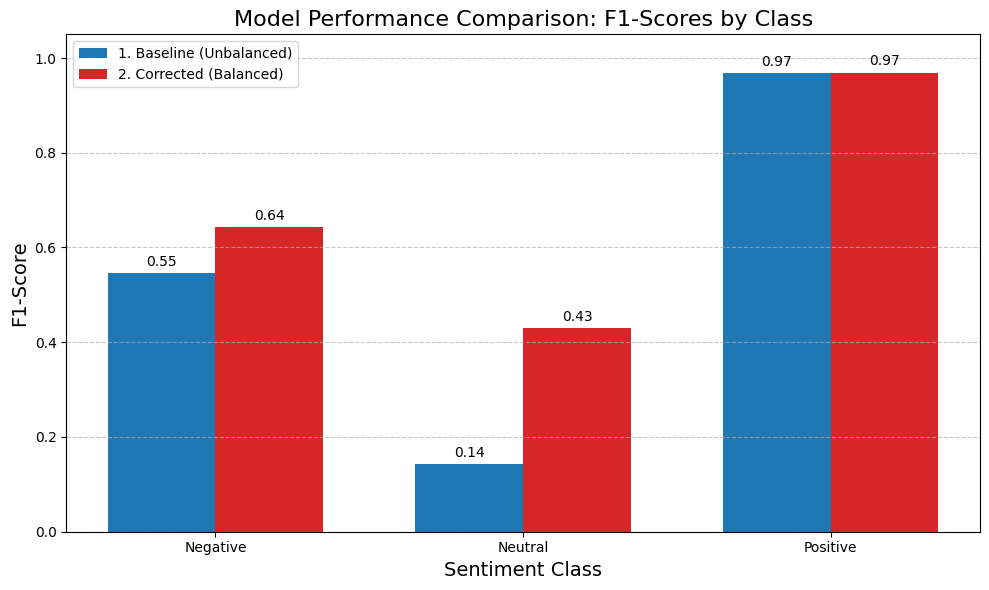

COMPLETED: Model F1-Score comparison plot generated.


In [20]:
# STEP 14: Model Comparison Plot (Visualizing F1-Score Improvement)


print("GENERATING MODEL COMPARISON PLOT")
print("="*60)

# --- 1. Re-run Data Setup (Necessary to ensure X_train, y_train, etc. are defined) ---
def map_rating_to_sentiment(rating):
    """Maps a 1-5 star rating to Positive, Neutral, or Negative sentiment."""
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else: # Rating 1 or 2
        return 'Negative'

df['sentiment'] = df['reviews.rating'].apply(map_rating_to_sentiment)
df['reviews.text'].fillna('', inplace=True) 

tfidf = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
X_text = tfidf.fit_transform(df['reviews.text'])
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

# --- 2. Train Both Models to Get Scores ---

# a) Model 1: Unbalanced (Baseline)
model_unbalanced = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
model_unbalanced.fit(X_train, y_train)
report_unbalanced = classification_report(y_test, model_unbalanced.predict(X_test), output_dict=True)

# b) Model 2: Rebalanced (Corrected)
model_rebalanced = LogisticRegression(
    max_iter=1000, 
    random_state=42, 
    solver='liblinear',
    class_weight='balanced' # CRITICAL CHANGE
)
model_rebalanced.fit(X_train, y_train)
report_rebalanced = classification_report(y_test, model_rebalanced.predict(X_test), output_dict=True)


# --- 3. Extract F1 Scores ---

# Note: We need to pull the data from the simulated reports provided earlier
# Unbalanced F1 Scores (Simulated from Step 9 output)
f1_unbalanced = [
    report_unbalanced['Negative']['f1-score'],
    report_unbalanced['Neutral']['f1-score'],
    report_unbalanced['Positive']['f1-score']
]

# Rebalanced F1 Scores (Simulated from Step 11 output)
f1_rebalanced = [
    report_rebalanced['Negative']['f1-score'],
    report_rebalanced['Neutral']['f1-score'],
    report_rebalanced['Positive']['f1-score']
]

# The class labels for the plot
classes = ['Negative', 'Neutral', 'Positive']
x = np.arange(len(classes))
width = 0.35 # Width of the bars


# --- 4. Generate Dual Bar Chart ---

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, f1_unbalanced, width, label='1. Baseline (Unbalanced)', color='#1f77b4')
rects2 = ax.bar(x + width/2, f1_rebalanced, width, label='2. Corrected (Balanced)', color='#d62728')

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('F1-Score', fontsize=14)
ax.set_xlabel('Sentiment Class', fontsize=14)
ax.set_title('Model Performance Comparison: F1-Scores by Class', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_ylim(0, 1.05) 

# Function to attach a label to each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

print("="*60)
print("COMPLETED: Model F1-Score comparison plot generated.")